In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [2]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as stats
import scipy.special as ss
import sortedcontainers as sc

import tqdm
import pickle

Trying to identify whether these 100 ll jumps are real, or some type of bug

### Load libraries

In [3]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [4]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


In [5]:
import hapaseg.coverage_DP as dp_cov
import hapaseg.a_cov_DP as dp_a_cov

In [6]:
colors = mpl.cm.get_cmap("tab20").colors

In [7]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 30

In [8]:
multidraw_df = pd.read_pickle('exome_results/acdp_df.pickle')

In [9]:
mcmc_data = np.load('exome_results/coverage_mcmc_clusters/cov_mcmc_collected_data.npz')
beta = mcmc_data['beta']

In [10]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

alpha=50 multidraw

In [11]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [16]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), beta, coverage_prior=True, seed_all_clusters=True)

23.011273255917313


In [17]:
a_cov_dp.run(1)

n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([1587, 1587, 1587, ...,   -1,   -1,   -1])],
 SortedDict({33: 7060, 79: 3, 569: 11628, 771: 865, 1018: 6902, 1240: 2683, 1271: 67, 1343: 35750, 1474: 2162, 1499: 3528, 1587: 42893, 1588: 1155, 1596: 420, 1612: 33043, 1613: 4911, 1656: 3240}))

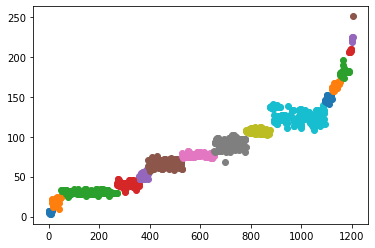

In [20]:
rs = []
for c in a_cov_dp.cluster_dict:
    rs.append((np.array([np.array(a_cov_dp.segment_r_list[i]).mean() for i in a_cov_dp.cluster_dict[c]]).mean(),c))
    
counter=0
for c in [t[1] for t in sorted(rs)]:
    vals = [np.array(a_cov_dp.segment_r_list[i]).mean() for i in a_cov_dp.cluster_dict[c]]
    plt.scatter(np.r_[counter:counter+len(vals)], vals)
    counter+= len(vals)

In [14]:
def _scatter_apply(x, minor, major):
    f = np.zeros(len(x))
    f[x.allele == -1] = minor / (minor + major)
    f[x.allele == 1] = major / (minor + major)
    locs = x.start_g.values + (x.end_g.values - x.start_g.values)/2
    return locs, f
ADP_dict = {}
for ADP, group in a_cov_dp.cov_df.loc[a_cov_dp.cov_df.dp_draw == 0].groupby('allelic_cluster'):
    ADP_dict[ADP] = (group['maj_count'].sum(), group['min_count'].sum())

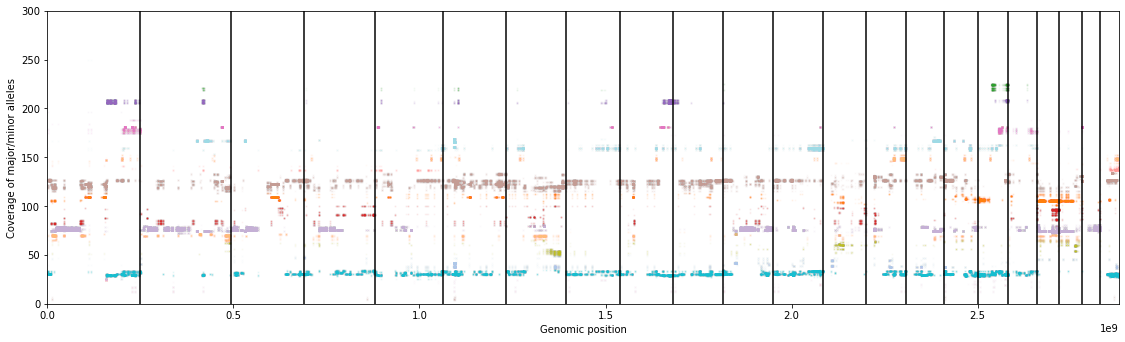

In [15]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for i, c in enumerate(a_cov_dp.cluster_dict.keys()):
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

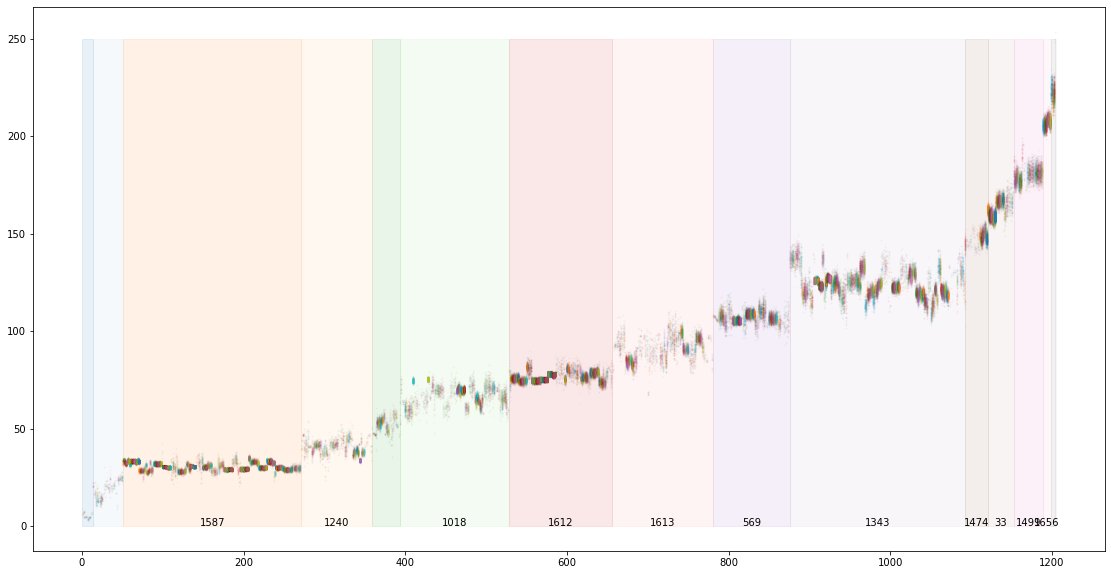

In [19]:
rs = []
for c in a_cov_dp.cluster_dict:
    rs.append((np.array([np.array(a_cov_dp.segment_r_list[i]).mean() for i in a_cov_dp.cluster_dict[c]]).mean(),c))
    
f, ax = plt.subplots(1, figsize = [19.2, 10])
counter=0
cc = 0
for c in [t[1] for t in sorted(rs)]:
    c0 = counter
    vals = [np.array(a_cov_dp.segment_r_list[i]) for i in a_cov_dp.cluster_dict[c]]
    
    for arr in vals:
        ax.scatter(np.repeat(counter, len(arr)), arr, marker = '.', alpha=0.05, s=4)
        counter+= 1
    ax.add_patch(mpl.patches.Rectangle((c0,0), counter-c0, 250, fill=True, alpha=0.10, color = colors[cc % len(colors)]))
    if a_cov_dp.cluster_counts[c]> 2000:
        ax.text(c0 + (counter-c0)/2, 0, '{}'.format(c), horizontalalignment='center')
    cc+=1